# Overview

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pmdarima.arima import auto_arima
from gensim.models import KeyedVectors
import spacy
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram
from pylab import rcParams
import re
from datetime import date
from catboost import Pool, CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
import holidays
from itertools import product


rcParams['figure.figsize'] = 10, 5
pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
item_categories = pd.read_csv("./data/item_categories.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")

In [4]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [8]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [9]:
# Check missing values
print("items:\n" + str(items.isna().sum()) + "\n")
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")

items:
item_name           0
item_id             0
item_category_id    0
dtype: int64

train:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

test:
ID         0
shop_id    0
item_id    0
dtype: int64



# Preprocessing

## train

In [10]:
print(f"The number of shops: {train['shop_id'].unique().shape[0]}")
print(f"The number of items: {train['item_id'].unique().shape[0]}")

The number of shops: 60
The number of items: 21807


### Format: date

In [4]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

### Anomalies in item_price column

In [12]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [13]:
train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,2013-05-15,4,25,2973,1249.5,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0
469951,2013-05-15,4,45,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0


In [5]:
missing_price = train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973) & (train['item_price'] > 0)]
train.loc[train['item_price'] < 0, "item_price"] = missing_price['item_price'].mean()

In [15]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


### Anomalies in item_cnt_day column

In [16]:
negative_train = train[train['item_cnt_day'] < 0]

In [17]:
# Statistics: item_price
train['item_price'].describe()

count    2.935849e+06
mean     8.908537e+02
std      1.729800e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [18]:
# Statistics: item_price of records with item_cnt_day < 0
negative_train['item_price'].describe()

count     7356.000000
mean      1442.945623
std       2419.680132
min          0.500000
25%        349.000000
50%        799.000000
75%       1699.000000
max      33490.000000
Name: item_price, dtype: float64

In [6]:
train['item_cnt_day'] = np.where(train['item_cnt_day'] < 0, 0, train['item_cnt_day'])

### Date aggregation

In [7]:
train_g = train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('item_cnt_month').reset_index()
train_g

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


## test

In [20]:
print(f"The number of shops in train data: {train['shop_id'].unique().shape[0]}")
print(f"The number of shops in test data: {test['shop_id'].unique().shape[0]}")

The number of shops in train data: 60
The number of shops in test data: 42


In [21]:
print("Items appear in test set but not in train set:")
len(set(test["item_id"].unique().tolist()) - set(train["item_id"].unique().tolist()))

Items appear in test set but not in train set:


363

# Feature Engineering

## Text Embeddings

In [8]:
ru_model = KeyedVectors.load_word2vec_format('../wiki.ru.vec')

In [9]:
def extract_feature(text_col):
    features = list()
    len_lst = list()
    nlp = spacy.load("ru_core_news_lg")
    fail_count = 0
    
    for i in tqdm(range(text_col.shape[0])):
        one_feature = list()
        tokens = nlp (text_col[i])
        for token in tokens:
            try:
                one_feature.append(ru_model.get_vector(token.text))
            except:
                continue
        if len(one_feature) > 0:
            one_feature = np.stack(one_feature).flatten()
        else:
            one_feature = np.zeros(300)
            fail_count += 1
        features.append(one_feature)
        len_lst.append(one_feature.shape[0])
        
    med = int(pd.Series(len_lst).max())
    print(f"Max: {med}")
    feature_tp = list()
    for item in features:
        if item.shape[0] < med:
            item = np.concatenate([item, np.zeros(med - item.shape[0])])
        else:
            item = item[:med]
        feature_tp.append(item)
    
    print(f"Failed: {fail_count}")
    features = np.stack(feature_tp)
    return features

In [10]:
def encoding_cate(ser, num):
    ser_df = ser.value_counts().to_frame('count').reset_index()
    ser_df = ser_df.loc[ser_df['count'] > num, 'index']
    print(f"The number of classes: {ser_df.shape[0] + 1}")
    ser_df = pd.DataFrame({"cate": ser_df.tolist(), "index": list(range(ser_df.shape[0], 0, -1))})
    return ser.to_frame('cate').merge(ser_df, on='cate', how='left').fillna(0)['index'].astype(int)

### item_categories

In [11]:
item_categories_feature = extract_feature(item_categories['item_category_name'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 286.16it/s]

Max: 1800
Failed: 1


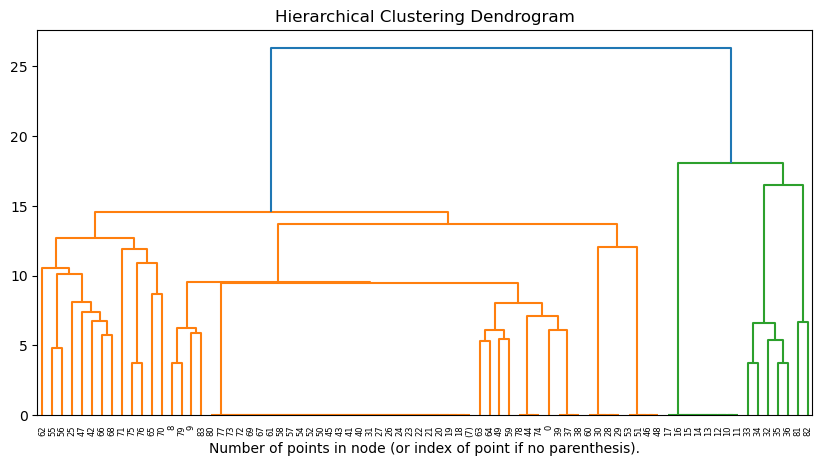

In [12]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


clustering = AgglomerativeClustering(distance_threshold=8, n_clusters=None).fit(item_categories_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [13]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 17
Check the shape of labels: 84
Labels: [ 2  6  6  6  6  6  6  6  5  5 11 11 11 11 11 11 11 11  6  6  6  6  6  6
  6 15  6  6 16 16 16  6  3  3  3  3  3  2  2  2  6  6  0  6  2  6  9  0
  9  7  6  9  6  9  6 12 12  6  6  7 16  6 10  7  7 14  0  6  0  6 13  8
  6  6  2  4  4  6  2  5  6  1  1  5]


In [14]:
item_categories['item_category_te'] = clustering.labels_
item_categories = item_categories.drop(columns=['item_category_name'])
item_categories

,item_category_id,item_category_te
0,0,2
1,1,6
2,2,6
3,3,6
4,4,6
...,...,...
79,79,5
80,80,6
81,81,1
82,82,1


In [15]:
cols = ["category_1", "category_2"]
item_categories_tfidf = pd.read_csv("./sales/_item_categories.csv", 
                                    usecols=["item_category_id", "category_1", "category_2"])

for col in cols:
    value_map = dict((v,i) for i,v in enumerate(item_categories_tfidf[col].unique()))
    item_categories_tfidf = item_categories_tfidf.replace({col:value_map})

item_categories_tfidf.head()

,item_category_id,category_1,category_2
0,0,0,0
1,1,1,1
2,2,1,2
3,3,1,3
4,4,1,4


### shops

In [16]:
shops_feature = extract_feature(shops['shop_name'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 293.46it/s]

Max: 1500
Failed: 2


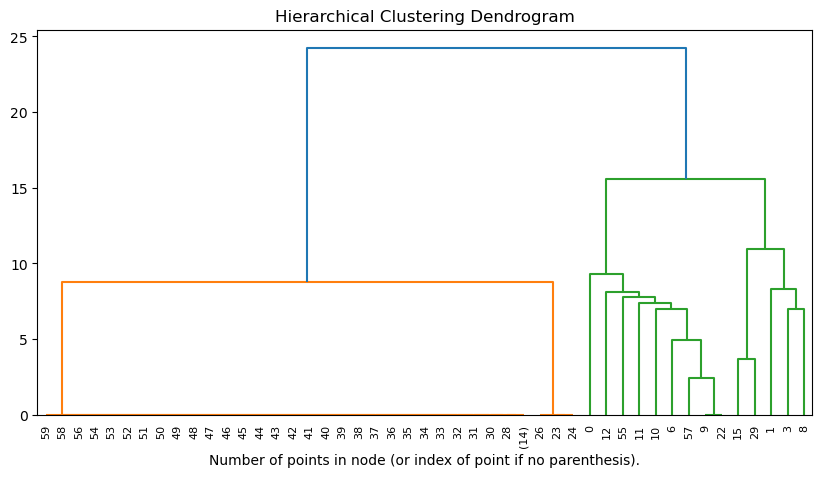

In [17]:
clustering = AgglomerativeClustering(distance_threshold=8, n_clusters=None).fit(shops_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [18]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 8
Check the shape of labels: 60
Labels: [4 6 5 1 5 5 0 5 1 0 0 0 7 5 5 3 5 5 5 5 5 5 0 2 2 5 2 5 5 3 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 5 0 5 5]


In [19]:
shop_name = shops['shop_name'].str.split(pat=' ', n=2)
def remove_stopping_words(lst):
    new_lst = list()
    for i in lst:
        i = i.strip(',?!"()')
        i = re.sub('"', '', i)
        i = re.sub('\(', '', i)
        if i != "":
            new_lst.append(i)
    return new_lst

shop_name_split = shop_name.apply(remove_stopping_words)
shop_city = shop_name_split.apply(lambda x: x[0])
shop_info = shop_name_split.apply(lambda x: x[1])

In [20]:
shops['city'] = encoding_cate(shop_city, 0)
shops['info'] = encoding_cate(shop_info, 1)
shops['shop_te'] = clustering.labels_
shops = shops.drop(columns=['shop_name'])
shops.head()

The number of classes: 32
The number of classes: 7


,shop_id,city,info,shop_te
0,0,30,2,4
1,1,30,6,6
2,2,10,6,5
3,3,2,4,1
4,4,3,6,5


In [21]:
cols = ["shop_kind", "city", "shop_brand"]
shops_tfidf = pd.read_csv("./sales/_shops.csv", usecols=["shop_id", "shop_kind", "city", "shop_brand"])

for col in cols:
    value_map = dict((v,i) for i,v in enumerate(shops_tfidf[col].unique()))
    shops_tfidf = shops_tfidf.replace({col:value_map})

shops_tfidf = shops_tfidf.rename(columns={'city': 'city2'})
shops_tfidf.head()

,shop_id,city2,shop_kind,shop_brand
0,0,0,0,0
1,1,0,1,1
2,2,1,1,2
3,3,2,2,3
4,4,3,1,4


### items

In [22]:
# The first word in item name
first_word = items['item_name'].str.split(pat=' ').apply(lambda x: x[0])
first_word = encoding_cate(first_word, 3)

The number of classes: 1224


In [23]:
# Information about the item in ()
def trans_lst(col):
    if len(col) > 0:
        item = col[0]
        item = item.lower()
        item = re.sub("\s", "", item)
        item = item.strip("\[\s\t\n")
    else:
        item = ""
    return item

item_addons = items['item_name'].str.findall(r'\((.+?)\)').apply(trans_lst)
item_addons = encoding_cate(item_addons, 35)

The number of classes: 27


In [24]:
# Information about the item in []
item_addons_2 = items['item_name'].str.findall(r'\[(.+?)[,\]...]').apply(trans_lst)
item_addons_2 = encoding_cate(item_addons_2, 10)

The number of classes: 14


In [25]:
items['first_word'] = first_word
items['item_addons'] = item_addons
items['item_addons_2'] = item_addons_2
items = items.drop(columns=['item_name'])
items

,item_id,item_category_id,first_word,item_addons,item_addons_2
0,0,40,0,0,13
1,1,76,0,26,12
2,2,40,0,0,13
3,3,40,0,0,13
4,4,40,0,0,13
...,...,...,...,...,...
22165,22165,31,0,26,12
22166,22166,54,0,26,9
22167,22167,49,0,0,13
22168,22168,62,0,26,13


In [26]:
items_tfidf = pd.read_csv("./sales/items.csv")
feature_count = 25
tfidf = TfidfVectorizer(max_features=feature_count)
items_df_item_name_text_features = tfidf.fit_transform(items_tfidf['item_name']).toarray().tolist()
items_tfidf["item_names_tf_idf"] = items_df_item_name_text_features
items_tfidf.drop('item_name', axis = 1, inplace = True)
items_tfidf

,item_id,item_category_id,item_names_tf_idf
0,0,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,76,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.63789760..."
2,2,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
22165,22165,31,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22166,22166,54,"[0.6725131066380127, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22167,22167,49,"[0.6991949949697428, 0.0, 0.0, 0.0, 0.71493101..."
22168,22168,62,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Structural Embeddings

### Date

In [8]:
holiday = pd.date_range(start='2013-01-01', end='2015-11-30').to_series().apply(lambda x: int(x in holidays.Russia()))
holiday = holiday.to_frame('check').reset_index()

def map_date_block_num(col):
    block = dict(list(enumerate(product(holiday['index'].dt.year.unique().tolist(), 
                                holiday['index'].dt.month.unique().tolist()))))
    block = {v: k for k, v in block.items()}
    key = (col.year, col.month)
    return block[key]

holiday['date_block_num'] = holiday['index'].apply(map_date_block_num)
holiday = holiday.groupby(by='date_block_num')['check'].sum().to_frame('n_holidays').reset_index()

In [9]:
day_of_week = pd.date_range(start='2013-01-01', end='2015-11-30').to_series().dt.isocalendar().day.to_frame('day').reset_index()

def map_date_block_num(col):
    block = dict(list(enumerate(product(day_of_week['index'].dt.year.unique().tolist(), 
                                day_of_week['index'].dt.month.unique().tolist()))))
    block = {v: k for k, v in block.items()}
    key = (col.year, col.month)
    return block[key]
day_of_week['date_block_num'] = day_of_week['index'].apply(map_date_block_num)
for i in range(1, 8):
    day_of_week[f'day_{i}'] = (day_of_week['day'] == i).astype(int)
    
day_of_week = day_of_week.drop(columns=['index', 'day']).groupby(by=['date_block_num']).sum().reset_index()

In [10]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['quarter'] = train['date'].dt.quarter
train['daysinmonth'] = train['date'].dt.daysinmonth
train['is_busday'] = np.is_busday(train['date'].dt.date.tolist()).astype(int)
train_busdays = train.loc[:, ['date', 'date_block_num', 'is_busday']].drop_duplicates()
train = train.merge(train_busdays.groupby(by=['date_block_num'])['is_busday'].sum().to_frame('n_busdays'),
                    on='date_block_num',
                    how='left')
train = train.drop(columns=['is_busday'])
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,quarter,daysinmonth,n_busdays
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,1,31,23
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,1,31,23
2,2013-01-05,0,25,2552,899.00,0.0,2013,1,1,31,23
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,1,31,23
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,1,31,23
...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015,10,4,31,22
2935845,2015-10-09,33,25,7460,299.00,1.0,2015,10,4,31,22
2935846,2015-10-14,33,25,7459,349.00,1.0,2015,10,4,31,22
2935847,2015-10-22,33,25,7440,299.00,1.0,2015,10,4,31,22


In [11]:
train_date = train.loc[:, ['date_block_num', 'shop_id', 'item_id', 'year', 'month', 
                           'quarter', 'daysinmonth', 'n_busdays']]
train_date = train_date.groupby(by=['date_block_num', 'shop_id', 'item_id']).median().astype(int).reset_index()
train_g = train_g.merge(train_date, on=['date_block_num', 'shop_id', 'item_id'], how='left')
train_g = train_g.merge(holiday, on='date_block_num', how='left')
train_g = train_g.merge(day_of_week, on='date_block_num', how='left')
train_g

,date_block_num,shop_id,item_id,item_cnt_month,year,month,quarter,daysinmonth,n_busdays,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,0,0,32,6.0,2013,1,1,31,23,8,4,5,5,5,4,4,4
1,0,0,33,3.0,2013,1,1,31,23,8,4,5,5,5,4,4,4
2,0,0,35,1.0,2013,1,1,31,23,8,4,5,5,5,4,4,4
3,0,0,43,1.0,2013,1,1,31,23,8,4,5,5,5,4,4,4
4,0,0,51,2.0,2013,1,1,31,23,8,4,5,5,5,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,2015,10,4,31,22,0,4,4,4,5,5,5,4
1609120,33,59,22088,2.0,2015,10,4,31,22,0,4,4,4,5,5,5,4
1609121,33,59,22091,1.0,2015,10,4,31,22,0,4,4,4,5,5,5,4
1609122,33,59,22100,1.0,2015,10,4,31,22,0,4,4,4,5,5,5,4


In [12]:
test['date_block_num'] = 34
test['year'] = 2015
test['month'] = 11
test['quarter'] = 4
test['daysinmonth'] = 30
test['n_busdays'] = np.busday_count('2015-11', '2015-12')
test = test.merge(holiday, on='date_block_num', how='left')
test = test.merge(day_of_week, on='date_block_num', how='left')
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,0,5,5037,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
1,1,5,5320,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
2,2,5,5233,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
3,3,5,5232,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
4,4,5,5268,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214196,214196,45,16188,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214197,214197,45,15757,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214198,214198,45,19648,34,2015,11,4,30,21,1,5,4,4,4,4,4,5


### Price

In [30]:
# Price Median
price_med = train.loc[:, ['item_id', 'item_price']].groupby(by=['item_id']).median().reset_index()
price_med = price_med.rename(columns={'item_price': 'item_price_med'})
train = train_g.merge(price_med, on='item_id', how='left')
test = test.merge(price_med, on='item_id', how='left')

In [31]:
train

,date_block_num,shop_id,item_id,item_cnt_month,year,month,quarter,daysinmonth,n_busdays,item_price_med
0,0,0,32,6.0,2013,1,1,31,23,221.0
1,0,0,33,3.0,2013,1,1,31,23,199.0
2,0,0,35,1.0,2013,1,1,31,23,399.0
3,0,0,43,1.0,2013,1,1,31,23,198.0
4,0,0,51,2.0,2013,1,1,31,23,249.0
...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,2015,10,4,31,22,79.0
1609120,33,59,22088,2.0,2015,10,4,31,22,79.0
1609121,33,59,22091,1.0,2015,10,4,31,22,109.0
1609122,33,59,22100,1.0,2015,10,4,31,22,629.0


In [32]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,item_price_med
0,0,5,5037,34,2015,11,4,30,21,1999.0
1,1,5,5320,34,2015,11,4,30,21,NaN
2,2,5,5233,34,2015,11,4,30,21,599.5
3,3,5,5232,34,2015,11,4,30,21,599.5
4,4,5,5268,34,2015,11,4,30,21,NaN
...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,199.0
214196,214196,45,16188,34,2015,11,4,30,21,1223.0
214197,214197,45,15757,34,2015,11,4,30,21,199.0
214198,214198,45,19648,34,2015,11,4,30,21,99.0


### Release Date

In [33]:
release = pd.concat([train_g.loc[:, ['date_block_num', 'item_id']],
                    test.loc[:, ['date_block_num', 'item_id']]])
release = release.groupby(by=['item_id']).min().reset_index()
release = release.rename(columns={'date_block_num': 'release_date'})
train = train.merge(release, on='item_id', how='left')
test = test.merge(release, on='item_id', how='left')

In [34]:
train

,date_block_num,shop_id,item_id,item_cnt_month,year,month,quarter,daysinmonth,n_busdays,item_price_med,release_date
0,0,0,32,6.0,2013,1,1,31,23,221.0,0
1,0,0,33,3.0,2013,1,1,31,23,199.0,0
2,0,0,35,1.0,2013,1,1,31,23,399.0,0
3,0,0,43,1.0,2013,1,1,31,23,198.0,0
4,0,0,51,2.0,2013,1,1,31,23,249.0,0
...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,2015,10,4,31,22,79.0,0
1609120,33,59,22088,2.0,2015,10,4,31,22,79.0,0
1609121,33,59,22091,1.0,2015,10,4,31,22,109.0,0
1609122,33,59,22100,1.0,2015,10,4,31,22,629.0,30


In [35]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,item_price_med,release_date
0,0,5,5037,34,2015,11,4,30,21,1999.0,20
1,1,5,5320,34,2015,11,4,30,21,NaN,34
2,2,5,5233,34,2015,11,4,30,21,599.5,27
3,3,5,5232,34,2015,11,4,30,21,599.5,31
4,4,5,5268,34,2015,11,4,30,21,NaN,34
...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,199.0,23
214196,214196,45,16188,34,2015,11,4,30,21,1223.0,32
214197,214197,45,15757,34,2015,11,4,30,21,199.0,0
214198,214198,45,19648,34,2015,11,4,30,21,99.0,23


### Sales Lag

In [36]:
for lag in [1, 4, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'item_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'item_id']).sum().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'item_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'item_id'], how='left')

In [37]:
train

,date_block_num,shop_id,item_id,item_cnt_month,year,month,quarter,daysinmonth,n_busdays,item_price_med,release_date,sales_lag1,sales_lag4,sales_lag6,sales_lag12
0,0,0,32,6.0,2013,1,1,31,23,221.0,0,NaN,NaN,NaN,NaN
1,0,0,33,3.0,2013,1,1,31,23,199.0,0,NaN,NaN,NaN,NaN
2,0,0,35,1.0,2013,1,1,31,23,399.0,0,NaN,NaN,NaN,NaN
3,0,0,43,1.0,2013,1,1,31,23,198.0,0,NaN,NaN,NaN,NaN
4,0,0,51,2.0,2013,1,1,31,23,249.0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,2015,10,4,31,22,79.0,0,61.0,60.0,67.0,83.0
1609120,33,59,22088,2.0,2015,10,4,31,22,79.0,0,130.0,131.0,142.0,141.0
1609121,33,59,22091,1.0,2015,10,4,31,22,109.0,0,43.0,35.0,35.0,25.0
1609122,33,59,22100,1.0,2015,10,4,31,22,629.0,30,94.0,NaN,NaN,NaN


In [38]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,item_price_med,release_date,sales_lag1,sales_lag4,sales_lag6,sales_lag12
0,0,5,5037,34,2015,11,4,30,21,1999.0,20,25.0,54.0,87.0,66.0
1,1,5,5320,34,2015,11,4,30,21,NaN,34,NaN,NaN,NaN,NaN
2,2,5,5233,34,2015,11,4,30,21,599.5,27,42.0,37.0,71.0,NaN
3,3,5,5232,34,2015,11,4,30,21,599.5,31,29.0,NaN,NaN,NaN
4,4,5,5268,34,2015,11,4,30,21,NaN,34,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,199.0,23,2.0,12.0,26.0,NaN
214196,214196,45,16188,34,2015,11,4,30,21,1223.0,32,1.0,NaN,NaN,NaN
214197,214197,45,15757,34,2015,11,4,30,21,199.0,0,5.0,4.0,11.0,9.0
214198,214198,45,19648,34,2015,11,4,30,21,99.0,23,2.0,2.0,4.0,NaN


## Merge DataFrames

In [39]:
# Merge
train = train.merge(items, on='item_id', how='left')
test = test.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')
test = test.merge(item_categories, on='item_category_id', how='left')
train = train.merge(item_categories_tfidf, on='item_category_id', how='left')
test = test.merge(item_categories_tfidf, on='item_category_id', how='left')
train = train.merge(shops, on='shop_id', how='left')
test = test.merge(shops, on='shop_id', how='left')
train = train.merge(shops_tfidf, on='shop_id', how='left')
test = test.merge(shops_tfidf, on='shop_id', how='left')
train = train.merge(items_tfidf, on=['item_id', 'item_category_id'], how='left')
test = test.merge(items_tfidf, on=['item_id', 'item_category_id'], how='left')

In [40]:
# Check missing values
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")

train:
date_block_num             0
shop_id                    0
item_id                    0
item_cnt_month             0
year                       0
month                      0
quarter                    0
daysinmonth                0
n_busdays                  0
item_price_med             0
release_date               0
sales_lag1            217880
sales_lag4            631096
sales_lag6            812141
sales_lag12          1197802
item_category_id           0
first_word                 0
item_addons                0
item_addons_2              0
item_category_te           0
category_1                 0
category_2                 0
city                       0
info                       0
shop_te                    0
city2                      0
shop_kind                  0
shop_brand                 0
item_names_tf_idf          0
dtype: int64

test:
ID                        0
shop_id                   0
item_id                   0
date_block_num            0
year                

In [41]:
train = train.fillna(0)
test = test.fillna(0)

In [42]:
# Prepare train/test data
train_y = train['item_cnt_month'].values
train_tf_idf = np.stack(train['item_names_tf_idf'])
train = train.drop(columns=['item_cnt_month', 'item_names_tf_idf'])

In [43]:
test_tf_idf = np.stack(test['item_names_tf_idf'])
test = test.drop(columns=['ID', 'item_names_tf_idf'])
test = test[train.columns.tolist()]

In [44]:
train_X = train.values
train_X = np.concatenate((train_X, train_tf_idf), axis=1)
test_X = test.values
test_X = np.concatenate((test_X, test_tf_idf), axis=1)

print(f'Shape of train X: {train_X.shape}.')
print(f'Shape of train y: {train_y.shape}.')
print(f'Shape of test X: {test_X.shape}.')

Shape of train X: (1609124, 52).
Shape of train y: (1609124,).
Shape of test X: (214200, 52).


In [45]:
np.save("./data/train_X.npy", train_X)
np.save("./data/train_y.npy", train_y)
np.save("./data/test_X.npy", test_X)

# Models

## ARIMA

### Example

In [15]:
trial = train.groupby(by=["date_block_num", "shop_id"])["item_cnt_day"].sum().to_frame(name='item_cnt_month').reset_index()
trial = trial.set_index('date_block_num')
trial

,shop_id,item_cnt_month
date_block_num,,
0,2,1151.0
0,3,767.0
0,4,2117.0
0,6,3699.0
0,7,2498.0
...,...,...
33,55,1972.0
33,56,1267.0
33,57,2319.0


In [34]:
# Auto ARIMA：Example
trial_ex = trial[trial['shop_id'] == 2].drop(columns=['shop_id'])
model = auto_arima(trial_ex, start_p=0, start_q=0, start_P=0, start_Q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -232.960
Date:                Mon, 28 Nov 2022   AIC                            471.921
Time:                        23:34:17   BIC                            476.500
Sample:                             0   HQIC                           473.482
                                 - 34                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    636.9515    194.972      3.267      0.001     254.813    1019.090
ar.L1          0.2947      0.184      1.601      0.109      -0.066       0.656
sigma2        5.2e+04   8361.650      6.219      0.000    3.56e+04    6.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                80.69
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             1.89
Prob(H) (two-sided):                  0.22   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

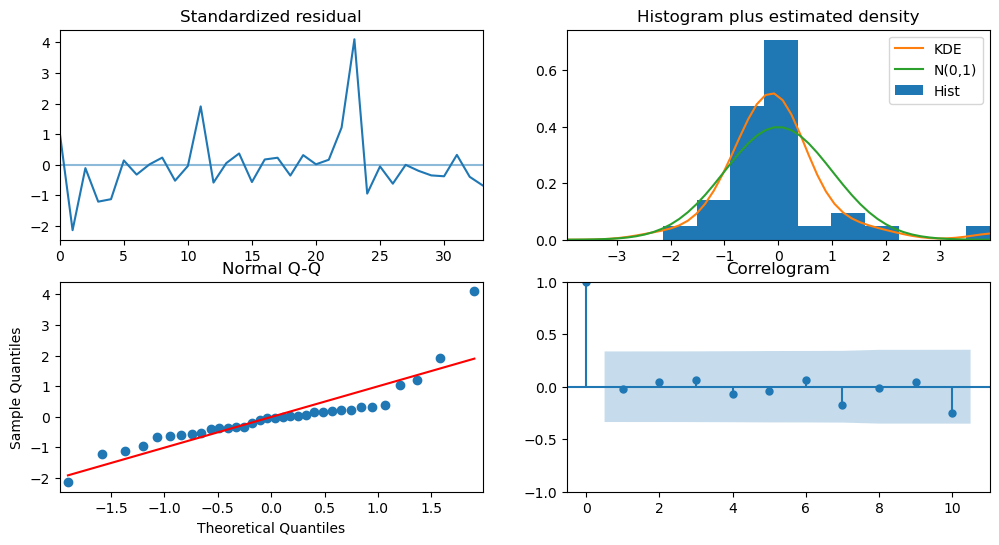

In [35]:
with plt.rc_context():
    plt.rc("figure", figsize=(12, 6))
    model.plot_diagnostics()
    plt.show()

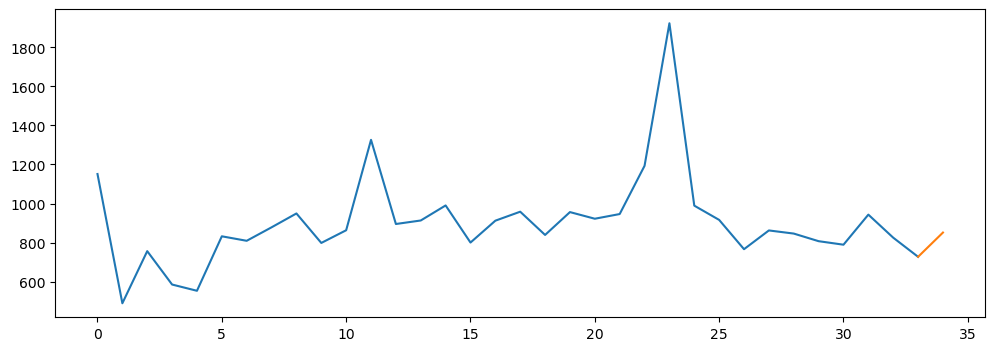

In [50]:
forecast = model.predict(n_periods=int(34 - trial_ex.index[-1]))

with plt.rc_context():
    plt.rc("figure", figsize=(12, 4))
    plt.plot(range(trial_ex.shape[0]), trial_ex['item_cnt_month'])
    plt.plot(range(trial_ex.shape[0] - 1, trial_ex.shape[0] + 34 - trial_ex.index[-1]), 
             [trial_ex['item_cnt_month'].iloc[-1], forecast.iloc[-1]])
    plt.show()

### Prediction

In [31]:
shop_lst = train['shop_id'].unique().tolist()
train_origin = pd.read_csv("./data/sales_train.csv")
per = train_origin.groupby(by=["item_id"])["item_cnt_day"].sum().to_frame(name='item_cnt').reset_index()
col = per["item_cnt"].copy()
per["item_per"] = col / col.sum()
pre_df  = pd.DataFrame(columns=["shop_id", "item_id", "item_cnt_month"])

for i in range(len(shop_lst)):
    trial_ex = trial[trial['shop_id'] == shop_lst[i]].drop(columns=['shop_id'])
    model = auto_arima(trial_ex, start_p=0, start_q=0, start_P=0, start_Q=0)
    forecast = model.predict(n_periods=int(34 - trial_ex.index[-1]))
    try:
        forecast = forecast.iloc[-1]
    except:
        forecast = trial_ex.iloc[0, -1]
    per_example = per[per['item_id'].isin(test.loc[(test['shop_id'] == shop_lst[i]), 'item_id'].unique().tolist())]
    per_example['item_cnt_month'] = per_example['item_per'] * forecast
    per_example['item_cnt_month'] = np.where(per_example['item_cnt_month'] > 20, 20, per_example['item_cnt_month'])
    per_example['item_cnt_month'] = np.where(per_example['item_cnt_month'] < 0, 0, per_example['item_cnt_month'])
    per_example['shop_id'] = shop_lst[i]
    per_example = per_example.drop(columns=["item_per", "item_cnt"])
    pre_df = pd.concat([pre_df, per_example], axis=0)
    
pre_df

/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

,shop_id,item_id,item_cnt_month
30,59,30,0.453507
31,59,31,0.311528
32,59,32,0.454159
33,59,33,0.181490
38,59,38,0.014328
...,...,...,...
21799,36,22162,0.063803
21800,36,22163,0.006846
21801,36,22164,0.045000
21803,36,22166,0.031765


In [35]:
test_arima = pd.merge(test, pre_df, on=['shop_id', 'item_id'], how = "left")
test_arima = test_arima.fillna(value=test_arima['item_cnt_month'].mean())
# test_arima = test_arima.fillna(0)
test_arima 

,ID,shop_id,item_id,item_category_id,date_block_num,price_m,item_cnt_month
0,0,5,5037,19,34,1499.000000,0.428533
1,1,5,5320,55,34,445.207669,0.000000
2,2,5,5233,19,34,1199.000000,0.171076
3,3,5,5232,23,34,1190.433333,0.047577
4,4,5,5268,20,34,445.207669,0.000000
...,...,...,...,...,...,...,...
214195,214195,45,18454,55,34,99.000000,0.087680
214196,214196,45,16188,64,34,1359.000000,0.000678
214197,214197,45,15757,55,34,229.000000,0.062750
214198,214198,45,19648,40,34,89.100000,0.009497


In [36]:
test_arima.isna().sum()

ID                  0
shop_id             0
item_id             0
item_category_id    0
date_block_num      0
price_m             0
item_cnt_month      0
dtype: int64

In [37]:
test_arima = test_arima.loc[:, ['ID', 'item_cnt_month']]
test_arima.to_csv('./results/submission_4.csv', index=False)

## Model Stacking

In [3]:
# Load data
train_X = np.load("./data/train_X.npy")
train_y = np.load("./data/train_y.npy")
test_X = np.load("./data/test_X.npy")

In [4]:
X_tr, X_va, y_tr, y_va = train_test_split(train_X, train_y, test_size=0.2, random_state=0)

In [51]:
# CatBoost 
train_pool = Pool(X_tr, y_tr) 
val_pool = Pool(X_va, y_va) 

model = CatBoostRegressor(early_stopping_rounds=3)
model.fit(train_pool, early_stopping_rounds=3)
pred_va = model.predict(val_pool)
print(mean_squared_error(y_va, pred_va, squared=False))

Learning rate set to 0.126914
0:	learn: 8.3072160	total: 203ms	remaining: 3m 22s
1:	learn: 8.0113824	total: 359ms	remaining: 2m 59s
2:	learn: 7.7662277	total: 512ms	remaining: 2m 50s
3:	learn: 7.5719937	total: 581ms	remaining: 2m 24s
4:	learn: 7.3847463	total: 640ms	remaining: 2m 7s
5:	learn: 7.2512962	total: 699ms	remaining: 1m 55s
6:	learn: 7.1278840	total: 758ms	remaining: 1m 47s
7:	learn: 7.0390677	total: 812ms	remaining: 1m 40s
8:	learn: 6.9620824	total: 869ms	remaining: 1m 35s
9:	learn: 6.9028311	total: 933ms	remaining: 1m 32s
10:	learn: 6.8285598	total: 1s	remaining: 1m 30s
11:	learn: 6.7781128	total: 1.07s	remaining: 1m 28s
12:	learn: 6.6997745	total: 1.14s	remaining: 1m 26s
13:	learn: 6.6591186	total: 1.22s	remaining: 1m 26s
14:	learn: 6.6194223	total: 1.29s	remaining: 1m 24s
15:	learn: 6.5742260	total: 1.36s	remaining: 1m 23s
16:	learn: 6.5437904	total: 1.43s	remaining: 1m 22s
17:	learn: 6.4926174	total: 1.49s	remaining: 1m 21s
18:	learn: 6.4631142	total: 1.56s	remaining: 1m 

162:	learn: 4.8907715	total: 10.8s	remaining: 55.7s
163:	learn: 4.8881075	total: 10.9s	remaining: 55.6s
164:	learn: 4.8855249	total: 11s	remaining: 55.5s
165:	learn: 4.8853283	total: 11s	remaining: 55.3s
166:	learn: 4.8797030	total: 11.1s	remaining: 55.3s
167:	learn: 4.8769775	total: 11.2s	remaining: 55.3s
168:	learn: 4.8748646	total: 11.2s	remaining: 55.3s
169:	learn: 4.8726223	total: 11.3s	remaining: 55.3s
170:	learn: 4.8691951	total: 11.4s	remaining: 55.3s
171:	learn: 4.8657382	total: 11.5s	remaining: 55.2s
172:	learn: 4.8632443	total: 11.5s	remaining: 55.2s
173:	learn: 4.8538206	total: 11.6s	remaining: 55.1s
174:	learn: 4.8509244	total: 11.7s	remaining: 55s
175:	learn: 4.8471902	total: 11.7s	remaining: 54.9s
176:	learn: 4.8417742	total: 11.8s	remaining: 54.8s
177:	learn: 4.8368461	total: 11.8s	remaining: 54.7s
178:	learn: 4.8338036	total: 11.9s	remaining: 54.6s
179:	learn: 4.8286197	total: 12s	remaining: 54.5s
180:	learn: 4.8266862	total: 12s	remaining: 54.4s
181:	learn: 4.8246846	

324:	learn: 4.4122320	total: 20.4s	remaining: 42.3s
325:	learn: 4.4052181	total: 20.4s	remaining: 42.2s
326:	learn: 4.4035056	total: 20.5s	remaining: 42.1s
327:	learn: 4.4021077	total: 20.5s	remaining: 42s
328:	learn: 4.3947318	total: 20.6s	remaining: 42s
329:	learn: 4.3936962	total: 20.6s	remaining: 41.9s
330:	learn: 4.3926028	total: 20.7s	remaining: 41.8s
331:	learn: 4.3914198	total: 20.7s	remaining: 41.7s
332:	learn: 4.3912870	total: 20.8s	remaining: 41.7s
333:	learn: 4.3899134	total: 20.9s	remaining: 41.6s
334:	learn: 4.3883250	total: 20.9s	remaining: 41.5s
335:	learn: 4.3862796	total: 21s	remaining: 41.5s
336:	learn: 4.3850782	total: 21.1s	remaining: 41.5s
337:	learn: 4.3829623	total: 21.1s	remaining: 41.4s
338:	learn: 4.3815783	total: 21.2s	remaining: 41.4s
339:	learn: 4.3807610	total: 21.3s	remaining: 41.3s
340:	learn: 4.3786664	total: 21.3s	remaining: 41.2s
341:	learn: 4.3774289	total: 21.4s	remaining: 41.1s
342:	learn: 4.3751166	total: 21.4s	remaining: 41s
343:	learn: 4.373300

485:	learn: 4.1047091	total: 30.4s	remaining: 32.2s
486:	learn: 4.1031350	total: 30.5s	remaining: 32.2s
487:	learn: 4.1020575	total: 30.6s	remaining: 32.1s
488:	learn: 4.1014202	total: 30.7s	remaining: 32s
489:	learn: 4.0970778	total: 30.7s	remaining: 32s
490:	learn: 4.0960905	total: 30.8s	remaining: 31.9s
491:	learn: 4.0954524	total: 30.9s	remaining: 31.9s
492:	learn: 4.0947611	total: 30.9s	remaining: 31.8s
493:	learn: 4.0928044	total: 31s	remaining: 31.8s
494:	learn: 4.0915996	total: 31.1s	remaining: 31.7s
495:	learn: 4.0905529	total: 31.1s	remaining: 31.6s
496:	learn: 4.0893809	total: 31.2s	remaining: 31.6s
497:	learn: 4.0881497	total: 31.2s	remaining: 31.5s
498:	learn: 4.0833994	total: 31.3s	remaining: 31.4s
499:	learn: 4.0829782	total: 31.3s	remaining: 31.3s
500:	learn: 4.0820984	total: 31.4s	remaining: 31.3s
501:	learn: 4.0814824	total: 31.4s	remaining: 31.2s
502:	learn: 4.0793364	total: 31.5s	remaining: 31.1s
503:	learn: 4.0760172	total: 31.6s	remaining: 31.1s
504:	learn: 4.0732

644:	learn: 3.8965265	total: 40.2s	remaining: 22.1s
645:	learn: 3.8956216	total: 40.2s	remaining: 22s
646:	learn: 3.8935725	total: 40.3s	remaining: 22s
647:	learn: 3.8925302	total: 40.4s	remaining: 21.9s
648:	learn: 3.8913271	total: 40.4s	remaining: 21.9s
649:	learn: 3.8886069	total: 40.5s	remaining: 21.8s
650:	learn: 3.8879004	total: 40.6s	remaining: 21.7s
651:	learn: 3.8873278	total: 40.6s	remaining: 21.7s
652:	learn: 3.8841213	total: 40.7s	remaining: 21.6s
653:	learn: 3.8834890	total: 40.8s	remaining: 21.6s
654:	learn: 3.8829568	total: 40.8s	remaining: 21.5s
655:	learn: 3.8820891	total: 40.9s	remaining: 21.4s
656:	learn: 3.8805338	total: 41s	remaining: 21.4s
657:	learn: 3.8799428	total: 41s	remaining: 21.3s
658:	learn: 3.8791007	total: 41.1s	remaining: 21.3s
659:	learn: 3.8784080	total: 41.1s	remaining: 21.2s
660:	learn: 3.8780434	total: 41.2s	remaining: 21.1s
661:	learn: 3.8775387	total: 41.3s	remaining: 21.1s
662:	learn: 3.8746320	total: 41.3s	remaining: 21s
663:	learn: 3.8738023	

805:	learn: 3.7107742	total: 50.7s	remaining: 12.2s
806:	learn: 3.7098831	total: 50.7s	remaining: 12.1s
807:	learn: 3.7095025	total: 50.8s	remaining: 12.1s
808:	learn: 3.7091699	total: 50.8s	remaining: 12s
809:	learn: 3.7085717	total: 50.9s	remaining: 11.9s
810:	learn: 3.7062366	total: 51s	remaining: 11.9s
811:	learn: 3.7046988	total: 51s	remaining: 11.8s
812:	learn: 3.7024787	total: 51.1s	remaining: 11.8s
813:	learn: 3.7016467	total: 51.2s	remaining: 11.7s
814:	learn: 3.7010985	total: 51.2s	remaining: 11.6s
815:	learn: 3.7000394	total: 51.3s	remaining: 11.6s
816:	learn: 3.6987086	total: 51.4s	remaining: 11.5s
817:	learn: 3.6975384	total: 51.4s	remaining: 11.4s
818:	learn: 3.6969672	total: 51.5s	remaining: 11.4s
819:	learn: 3.6964859	total: 51.6s	remaining: 11.3s
820:	learn: 3.6943783	total: 51.6s	remaining: 11.3s
821:	learn: 3.6938330	total: 51.7s	remaining: 11.2s
822:	learn: 3.6923916	total: 51.7s	remaining: 11.1s
823:	learn: 3.6918912	total: 51.8s	remaining: 11.1s
824:	learn: 3.6914

966:	learn: 3.5924190	total: 1m	remaining: 2.07s
967:	learn: 3.5919245	total: 1m	remaining: 2s
968:	learn: 3.5915524	total: 1m	remaining: 1.94s
969:	learn: 3.5914500	total: 1m	remaining: 1.88s
970:	learn: 3.5894379	total: 1m	remaining: 1.82s
971:	learn: 3.5887706	total: 1m	remaining: 1.75s
972:	learn: 3.5879779	total: 1m	remaining: 1.69s
973:	learn: 3.5870166	total: 1m 1s	remaining: 1.63s
974:	learn: 3.5847517	total: 1m 1s	remaining: 1.57s
975:	learn: 3.5841392	total: 1m 1s	remaining: 1.5s
976:	learn: 3.5834795	total: 1m 1s	remaining: 1.44s
977:	learn: 3.5829011	total: 1m 1s	remaining: 1.38s
978:	learn: 3.5824799	total: 1m 1s	remaining: 1.31s
979:	learn: 3.5816513	total: 1m 1s	remaining: 1.25s
980:	learn: 3.5810664	total: 1m 1s	remaining: 1.19s
981:	learn: 3.5806588	total: 1m 1s	remaining: 1.13s
982:	learn: 3.5792218	total: 1m 1s	remaining: 1.06s
983:	learn: 3.5789073	total: 1m 1s	remaining: 1s
984:	learn: 3.5778260	total: 1m 1s	remaining: 939ms
985:	learn: 3.5759734	total: 1m 1s	remai

In [52]:
# XGBoost
# model = xgb.XGBRegressor(gamma=0,
#                          eta=0.3,
#                          max_depth=6,
#                          n_estimators=180)
model = xgb.XGBRegressor()
model.fit(X_tr, y_tr)
pred_va = model.predict(X_va)
print(mean_squared_error(y_va, pred_va, squared=False))

5.350508074169821


In [54]:
# LightGBM
param = {'metric': 'rmse', 'learning_rate': 0.1}
model = lgb.train(param, lgb.Dataset(X_tr, label=y_tr))
pred_va = model.predict(X_va)
print(mean_squared_error(y_va, pred_va, squared=False))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3634
[LightGBM] [Info] Number of data points in the train set: 1287299, number of used features: 52
[LightGBM] [Info] Start training from score 2.268671
5.5919098471393855


In [5]:
# Stacking
final_estimator = GradientBoostingRegressor()
param = {'metric': 'rmse', 'learning_rate': 0.1}
estimators = [('cat', CatBoostRegressor(early_stopping_rounds=3)),
              ('xgb', xgb.XGBRegressor()),
              ('lgb', lgb.LGBMRegressor()),
              ('lasso', linear_model.Lasso()),
              ('ridge',linear_model.Ridge())]
model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
model.fit(X_tr, y_tr)
pred_va = model.predict(X_va)
print(f'rmse: {mean_squared_error(y_va, pred_va, squared=False)}.')

Learning rate set to 0.126914
0:	learn: 8.3072160	total: 195ms	remaining: 3m 14s
1:	learn: 8.0113824	total: 320ms	remaining: 2m 39s
2:	learn: 7.7662277	total: 454ms	remaining: 2m 30s
3:	learn: 7.5719937	total: 572ms	remaining: 2m 22s
4:	learn: 7.3847463	total: 652ms	remaining: 2m 9s
5:	learn: 7.2512962	total: 715ms	remaining: 1m 58s
6:	learn: 7.1278840	total: 770ms	remaining: 1m 49s
7:	learn: 7.0390677	total: 823ms	remaining: 1m 42s
8:	learn: 6.9620824	total: 878ms	remaining: 1m 36s
9:	learn: 6.9028311	total: 944ms	remaining: 1m 33s
10:	learn: 6.8285598	total: 1s	remaining: 1m 30s
11:	learn: 6.7781128	total: 1.06s	remaining: 1m 27s
12:	learn: 6.6997745	total: 1.11s	remaining: 1m 24s
13:	learn: 6.6591186	total: 1.18s	remaining: 1m 22s
14:	learn: 6.6194223	total: 1.22s	remaining: 1m 20s
15:	learn: 6.5742260	total: 1.28s	remaining: 1m 18s
16:	learn: 6.5437904	total: 1.34s	remaining: 1m 17s
17:	learn: 6.4926174	total: 1.4s	remaining: 1m 16s
18:	learn: 6.4631142	total: 1.47s	remaining: 1m 1

161:	learn: 4.8955373	total: 11s	remaining: 56.8s
162:	learn: 4.8907715	total: 11.1s	remaining: 57s
163:	learn: 4.8881075	total: 11.2s	remaining: 57s
164:	learn: 4.8855249	total: 11.3s	remaining: 57.1s
165:	learn: 4.8853283	total: 11.4s	remaining: 57s
166:	learn: 4.8797030	total: 11.5s	remaining: 57.1s
167:	learn: 4.8769775	total: 11.5s	remaining: 57.1s
168:	learn: 4.8748646	total: 11.6s	remaining: 57.2s
169:	learn: 4.8726223	total: 11.7s	remaining: 57.2s
170:	learn: 4.8691951	total: 11.8s	remaining: 57.2s
171:	learn: 4.8657382	total: 11.9s	remaining: 57.2s
172:	learn: 4.8632443	total: 12s	remaining: 57.4s
173:	learn: 4.8538206	total: 12.1s	remaining: 57.5s
174:	learn: 4.8509244	total: 12.2s	remaining: 57.5s
175:	learn: 4.8471902	total: 12.3s	remaining: 57.5s
176:	learn: 4.8417742	total: 12.4s	remaining: 57.5s
177:	learn: 4.8368461	total: 12.4s	remaining: 57.5s
178:	learn: 4.8338036	total: 12.5s	remaining: 57.5s
179:	learn: 4.8286197	total: 12.6s	remaining: 57.5s
180:	learn: 4.8266862	

320:	learn: 4.4272498	total: 21.6s	remaining: 45.7s
321:	learn: 4.4189100	total: 21.6s	remaining: 45.6s
322:	learn: 4.4162617	total: 21.7s	remaining: 45.5s
323:	learn: 4.4147987	total: 21.8s	remaining: 45.4s
324:	learn: 4.4122320	total: 21.8s	remaining: 45.3s
325:	learn: 4.4052181	total: 21.9s	remaining: 45.2s
326:	learn: 4.4035056	total: 21.9s	remaining: 45.2s
327:	learn: 4.4021077	total: 22s	remaining: 45.1s
328:	learn: 4.3947318	total: 22.1s	remaining: 45s
329:	learn: 4.3936962	total: 22.1s	remaining: 44.9s
330:	learn: 4.3926028	total: 22.2s	remaining: 44.9s
331:	learn: 4.3914198	total: 22.3s	remaining: 44.8s
332:	learn: 4.3912870	total: 22.3s	remaining: 44.7s
333:	learn: 4.3899134	total: 22.4s	remaining: 44.6s
334:	learn: 4.3883250	total: 22.4s	remaining: 44.5s
335:	learn: 4.3862796	total: 22.5s	remaining: 44.4s
336:	learn: 4.3850782	total: 22.6s	remaining: 44.4s
337:	learn: 4.3829623	total: 22.6s	remaining: 44.3s
338:	learn: 4.3815783	total: 22.7s	remaining: 44.2s
339:	learn: 4.38

480:	learn: 4.1076141	total: 31s	remaining: 33.4s
481:	learn: 4.1070803	total: 31s	remaining: 33.3s
482:	learn: 4.1063583	total: 31.1s	remaining: 33.2s
483:	learn: 4.1059408	total: 31.1s	remaining: 33.2s
484:	learn: 4.1050835	total: 31.2s	remaining: 33.1s
485:	learn: 4.1047091	total: 31.2s	remaining: 33s
486:	learn: 4.1031350	total: 31.3s	remaining: 32.9s
487:	learn: 4.1020575	total: 31.3s	remaining: 32.9s
488:	learn: 4.1014202	total: 31.4s	remaining: 32.8s
489:	learn: 4.0970778	total: 31.4s	remaining: 32.7s
490:	learn: 4.0960905	total: 31.5s	remaining: 32.6s
491:	learn: 4.0954524	total: 31.5s	remaining: 32.6s
492:	learn: 4.0947611	total: 31.6s	remaining: 32.5s
493:	learn: 4.0928044	total: 31.7s	remaining: 32.4s
494:	learn: 4.0915996	total: 31.7s	remaining: 32.4s
495:	learn: 4.0905529	total: 31.8s	remaining: 32.3s
496:	learn: 4.0893809	total: 31.8s	remaining: 32.2s
497:	learn: 4.0881497	total: 31.9s	remaining: 32.2s
498:	learn: 4.0833994	total: 32s	remaining: 32.1s
499:	learn: 4.082978

640:	learn: 3.8996271	total: 40.6s	remaining: 22.7s
641:	learn: 3.8990972	total: 40.6s	remaining: 22.7s
642:	learn: 3.8973157	total: 40.7s	remaining: 22.6s
643:	learn: 3.8968274	total: 40.7s	remaining: 22.5s
644:	learn: 3.8965265	total: 40.8s	remaining: 22.4s
645:	learn: 3.8956216	total: 40.8s	remaining: 22.4s
646:	learn: 3.8935725	total: 40.9s	remaining: 22.3s
647:	learn: 3.8925302	total: 41s	remaining: 22.3s
648:	learn: 3.8913271	total: 41s	remaining: 22.2s
649:	learn: 3.8886069	total: 41.1s	remaining: 22.1s
650:	learn: 3.8879004	total: 41.2s	remaining: 22.1s
651:	learn: 3.8873278	total: 41.2s	remaining: 22s
652:	learn: 3.8841213	total: 41.3s	remaining: 21.9s
653:	learn: 3.8834890	total: 41.4s	remaining: 21.9s
654:	learn: 3.8829568	total: 41.4s	remaining: 21.8s
655:	learn: 3.8820891	total: 41.5s	remaining: 21.8s
656:	learn: 3.8805338	total: 41.5s	remaining: 21.7s
657:	learn: 3.8799428	total: 41.6s	remaining: 21.6s
658:	learn: 3.8791007	total: 41.7s	remaining: 21.6s
659:	learn: 3.8784

800:	learn: 3.7167874	total: 50s	remaining: 12.4s
801:	learn: 3.7161954	total: 50.1s	remaining: 12.4s
802:	learn: 3.7156371	total: 50.1s	remaining: 12.3s
803:	learn: 3.7150921	total: 50.2s	remaining: 12.2s
804:	learn: 3.7135934	total: 50.3s	remaining: 12.2s
805:	learn: 3.7107742	total: 50.3s	remaining: 12.1s
806:	learn: 3.7098831	total: 50.4s	remaining: 12.1s
807:	learn: 3.7095025	total: 50.4s	remaining: 12s
808:	learn: 3.7091699	total: 50.5s	remaining: 11.9s
809:	learn: 3.7085717	total: 50.6s	remaining: 11.9s
810:	learn: 3.7062366	total: 50.6s	remaining: 11.8s
811:	learn: 3.7046988	total: 50.7s	remaining: 11.7s
812:	learn: 3.7024787	total: 50.8s	remaining: 11.7s
813:	learn: 3.7016467	total: 50.8s	remaining: 11.6s
814:	learn: 3.7010985	total: 50.9s	remaining: 11.6s
815:	learn: 3.7000394	total: 51s	remaining: 11.5s
816:	learn: 3.6987086	total: 51s	remaining: 11.4s
817:	learn: 3.6975384	total: 51.1s	remaining: 11.4s
818:	learn: 3.6969672	total: 51.2s	remaining: 11.3s
819:	learn: 3.696485

960:	learn: 3.5973439	total: 1m	remaining: 2.47s
961:	learn: 3.5967925	total: 1m	remaining: 2.41s
962:	learn: 3.5961733	total: 1m 1s	remaining: 2.35s
963:	learn: 3.5936925	total: 1m 1s	remaining: 2.28s
964:	learn: 3.5935514	total: 1m 1s	remaining: 2.22s
965:	learn: 3.5930301	total: 1m 1s	remaining: 2.16s
966:	learn: 3.5924190	total: 1m 1s	remaining: 2.1s
967:	learn: 3.5919245	total: 1m 1s	remaining: 2.04s
968:	learn: 3.5915524	total: 1m 1s	remaining: 1.98s
969:	learn: 3.5914500	total: 1m 1s	remaining: 1.91s
970:	learn: 3.5894379	total: 1m 2s	remaining: 1.85s
971:	learn: 3.5887706	total: 1m 2s	remaining: 1.79s
972:	learn: 3.5879779	total: 1m 2s	remaining: 1.73s
973:	learn: 3.5870166	total: 1m 2s	remaining: 1.66s
974:	learn: 3.5847517	total: 1m 2s	remaining: 1.6s
975:	learn: 3.5841392	total: 1m 2s	remaining: 1.54s
976:	learn: 3.5834795	total: 1m 2s	remaining: 1.47s
977:	learn: 3.5829011	total: 1m 2s	remaining: 1.41s
978:	learn: 3.5824799	total: 1m 2s	remaining: 1.35s
979:	learn: 3.581651

121:	learn: 4.9743557	total: 6.34s	remaining: 45.6s
122:	learn: 4.9700323	total: 6.4s	remaining: 45.7s
123:	learn: 4.9677993	total: 6.46s	remaining: 45.6s
124:	learn: 4.9636734	total: 6.51s	remaining: 45.6s
125:	learn: 4.9591027	total: 6.55s	remaining: 45.5s
126:	learn: 4.9536450	total: 6.61s	remaining: 45.4s
127:	learn: 4.9496861	total: 6.68s	remaining: 45.5s
128:	learn: 4.9453369	total: 6.74s	remaining: 45.5s
129:	learn: 4.9421996	total: 6.8s	remaining: 45.5s
130:	learn: 4.9381023	total: 6.88s	remaining: 45.6s
131:	learn: 4.9356638	total: 6.95s	remaining: 45.7s
132:	learn: 4.9187599	total: 7.01s	remaining: 45.7s
133:	learn: 4.9126361	total: 7.07s	remaining: 45.7s
134:	learn: 4.9089626	total: 7.12s	remaining: 45.6s
135:	learn: 4.8937186	total: 7.16s	remaining: 45.5s
136:	learn: 4.8888001	total: 7.21s	remaining: 45.4s
137:	learn: 4.8873190	total: 7.26s	remaining: 45.4s
138:	learn: 4.8830411	total: 7.31s	remaining: 45.3s
139:	learn: 4.8811895	total: 7.36s	remaining: 45.2s
140:	learn: 4.

281:	learn: 4.3771362	total: 14.6s	remaining: 37.1s
282:	learn: 4.3734619	total: 14.6s	remaining: 37.1s
283:	learn: 4.3719756	total: 14.7s	remaining: 37s
284:	learn: 4.3705065	total: 14.7s	remaining: 37s
285:	learn: 4.3694458	total: 14.8s	remaining: 36.9s
286:	learn: 4.3685692	total: 14.8s	remaining: 36.8s
287:	learn: 4.3639717	total: 14.9s	remaining: 36.8s
288:	learn: 4.3604239	total: 14.9s	remaining: 36.7s
289:	learn: 4.3583635	total: 15s	remaining: 36.7s
290:	learn: 4.3551455	total: 15s	remaining: 36.6s
291:	learn: 4.3542734	total: 15.1s	remaining: 36.5s
292:	learn: 4.3530083	total: 15.1s	remaining: 36.5s
293:	learn: 4.3511597	total: 15.2s	remaining: 36.4s
294:	learn: 4.3430702	total: 15.2s	remaining: 36.3s
295:	learn: 4.3360857	total: 15.2s	remaining: 36.2s
296:	learn: 4.3329974	total: 15.3s	remaining: 36.2s
297:	learn: 4.3268541	total: 15.3s	remaining: 36.1s
298:	learn: 4.3243860	total: 15.4s	remaining: 36s
299:	learn: 4.3234895	total: 15.4s	remaining: 36s
300:	learn: 4.3177369	to

443:	learn: 4.0510234	total: 22.6s	remaining: 28.4s
444:	learn: 4.0502266	total: 22.7s	remaining: 28.3s
445:	learn: 4.0496127	total: 22.8s	remaining: 28.3s
446:	learn: 4.0485329	total: 22.8s	remaining: 28.2s
447:	learn: 4.0478830	total: 22.9s	remaining: 28.2s
448:	learn: 4.0466319	total: 22.9s	remaining: 28.1s
449:	learn: 4.0460620	total: 23s	remaining: 28.1s
450:	learn: 4.0441141	total: 23s	remaining: 28s
451:	learn: 4.0415003	total: 23.1s	remaining: 28s
452:	learn: 4.0403019	total: 23.1s	remaining: 27.9s
453:	learn: 4.0392525	total: 23.2s	remaining: 27.9s
454:	learn: 4.0375574	total: 23.2s	remaining: 27.8s
455:	learn: 4.0366975	total: 23.3s	remaining: 27.8s
456:	learn: 4.0349818	total: 23.3s	remaining: 27.7s
457:	learn: 4.0339496	total: 23.4s	remaining: 27.7s
458:	learn: 4.0330420	total: 23.4s	remaining: 27.6s
459:	learn: 4.0322790	total: 23.5s	remaining: 27.5s
460:	learn: 4.0314925	total: 23.5s	remaining: 27.5s
461:	learn: 4.0283872	total: 23.5s	remaining: 27.4s
462:	learn: 4.027606

602:	learn: 3.8616467	total: 30.5s	remaining: 20.1s
603:	learn: 3.8612652	total: 30.6s	remaining: 20s
604:	learn: 3.8599483	total: 30.6s	remaining: 20s
605:	learn: 3.8593747	total: 30.7s	remaining: 19.9s
606:	learn: 3.8587365	total: 30.7s	remaining: 19.9s
607:	learn: 3.8576929	total: 30.8s	remaining: 19.9s
608:	learn: 3.8569181	total: 30.8s	remaining: 19.8s
609:	learn: 3.8561334	total: 30.9s	remaining: 19.7s
610:	learn: 3.8546738	total: 30.9s	remaining: 19.7s
611:	learn: 3.8539070	total: 31s	remaining: 19.6s
612:	learn: 3.8532806	total: 31s	remaining: 19.6s
613:	learn: 3.8512589	total: 31.1s	remaining: 19.6s
614:	learn: 3.8506437	total: 31.2s	remaining: 19.5s
615:	learn: 3.8481955	total: 31.2s	remaining: 19.5s
616:	learn: 3.8466666	total: 31.3s	remaining: 19.4s
617:	learn: 3.8450091	total: 31.3s	remaining: 19.4s
618:	learn: 3.8442981	total: 31.4s	remaining: 19.3s
619:	learn: 3.8437649	total: 31.5s	remaining: 19.3s
620:	learn: 3.8433864	total: 31.5s	remaining: 19.2s
621:	learn: 3.839203

762:	learn: 3.6990403	total: 38.4s	remaining: 11.9s
763:	learn: 3.6971849	total: 38.4s	remaining: 11.9s
764:	learn: 3.6965210	total: 38.5s	remaining: 11.8s
765:	learn: 3.6962329	total: 38.5s	remaining: 11.8s
766:	learn: 3.6959065	total: 38.6s	remaining: 11.7s
767:	learn: 3.6956437	total: 38.6s	remaining: 11.7s
768:	learn: 3.6954154	total: 38.7s	remaining: 11.6s
769:	learn: 3.6947498	total: 38.7s	remaining: 11.6s
770:	learn: 3.6938406	total: 38.7s	remaining: 11.5s
771:	learn: 3.6933842	total: 38.8s	remaining: 11.5s
772:	learn: 3.6931001	total: 38.8s	remaining: 11.4s
773:	learn: 3.6923827	total: 38.9s	remaining: 11.4s
774:	learn: 3.6914410	total: 38.9s	remaining: 11.3s
775:	learn: 3.6905791	total: 39s	remaining: 11.3s
776:	learn: 3.6901233	total: 39s	remaining: 11.2s
777:	learn: 3.6889737	total: 39.1s	remaining: 11.2s
778:	learn: 3.6886353	total: 39.1s	remaining: 11.1s
779:	learn: 3.6877492	total: 39.2s	remaining: 11s
780:	learn: 3.6871239	total: 39.2s	remaining: 11s
781:	learn: 3.686833

923:	learn: 3.5712209	total: 45.9s	remaining: 3.77s
924:	learn: 3.5709276	total: 45.9s	remaining: 3.72s
925:	learn: 3.5700589	total: 46s	remaining: 3.67s
926:	learn: 3.5698378	total: 46s	remaining: 3.62s
927:	learn: 3.5687626	total: 46s	remaining: 3.57s
928:	learn: 3.5675319	total: 46.1s	remaining: 3.52s
929:	learn: 3.5670756	total: 46.1s	remaining: 3.47s
930:	learn: 3.5663877	total: 46.2s	remaining: 3.42s
931:	learn: 3.5659067	total: 46.2s	remaining: 3.37s
932:	learn: 3.5655016	total: 46.3s	remaining: 3.32s
933:	learn: 3.5647425	total: 46.3s	remaining: 3.27s
934:	learn: 3.5641939	total: 46.4s	remaining: 3.22s
935:	learn: 3.5637355	total: 46.4s	remaining: 3.17s
936:	learn: 3.5633611	total: 46.5s	remaining: 3.12s
937:	learn: 3.5623015	total: 46.5s	remaining: 3.07s
938:	learn: 3.5619262	total: 46.6s	remaining: 3.02s
939:	learn: 3.5607752	total: 46.6s	remaining: 2.98s
940:	learn: 3.5601423	total: 46.7s	remaining: 2.93s
941:	learn: 3.5598065	total: 46.7s	remaining: 2.88s
942:	learn: 3.5592

86:	learn: 5.2920218	total: 5.05s	remaining: 53.1s
87:	learn: 5.2870262	total: 5.11s	remaining: 52.9s
88:	learn: 5.2744008	total: 5.16s	remaining: 52.9s
89:	learn: 5.2629653	total: 5.23s	remaining: 52.9s
90:	learn: 5.2590683	total: 5.29s	remaining: 52.9s
91:	learn: 5.2519961	total: 5.36s	remaining: 52.9s
92:	learn: 5.2463240	total: 5.41s	remaining: 52.8s
93:	learn: 5.2386369	total: 5.47s	remaining: 52.8s
94:	learn: 5.2288890	total: 5.53s	remaining: 52.7s
95:	learn: 5.2209313	total: 5.58s	remaining: 52.5s
96:	learn: 5.2134975	total: 5.63s	remaining: 52.4s
97:	learn: 5.2099928	total: 5.68s	remaining: 52.3s
98:	learn: 5.2052095	total: 5.73s	remaining: 52.2s
99:	learn: 5.2015113	total: 5.79s	remaining: 52.1s
100:	learn: 5.1974818	total: 5.84s	remaining: 52s
101:	learn: 5.1888984	total: 5.89s	remaining: 51.8s
102:	learn: 5.1764821	total: 5.94s	remaining: 51.7s
103:	learn: 5.1713639	total: 5.99s	remaining: 51.6s
104:	learn: 5.1674281	total: 6.04s	remaining: 51.5s
105:	learn: 5.1631646	total:

246:	learn: 4.5722123	total: 17.1s	remaining: 52.1s
247:	learn: 4.5708111	total: 17.2s	remaining: 52.1s
248:	learn: 4.5691690	total: 17.3s	remaining: 52.1s
249:	learn: 4.5677291	total: 17.4s	remaining: 52.1s
250:	learn: 4.5664843	total: 17.5s	remaining: 52.1s
251:	learn: 4.5619480	total: 17.5s	remaining: 52.1s
252:	learn: 4.5591094	total: 17.6s	remaining: 52.1s
253:	learn: 4.5581153	total: 17.7s	remaining: 52.1s
254:	learn: 4.5558330	total: 17.8s	remaining: 52s
255:	learn: 4.5540830	total: 17.9s	remaining: 52.1s
256:	learn: 4.5509957	total: 18s	remaining: 52.1s
257:	learn: 4.5493467	total: 18.1s	remaining: 52.1s
258:	learn: 4.5480291	total: 18.2s	remaining: 52s
259:	learn: 4.5457136	total: 18.3s	remaining: 52s
260:	learn: 4.5434904	total: 18.4s	remaining: 52s
261:	learn: 4.5416229	total: 18.5s	remaining: 52s
262:	learn: 4.5396071	total: 18.6s	remaining: 52.1s
263:	learn: 4.5385045	total: 18.7s	remaining: 52s
264:	learn: 4.5376021	total: 18.8s	remaining: 52.1s
265:	learn: 4.5340897	tota

406:	learn: 4.2304481	total: 27.7s	remaining: 40.3s
407:	learn: 4.2287549	total: 27.7s	remaining: 40.2s
408:	learn: 4.2277743	total: 27.8s	remaining: 40.2s
409:	learn: 4.2252770	total: 27.9s	remaining: 40.1s
410:	learn: 4.2247230	total: 27.9s	remaining: 40s
411:	learn: 4.2226828	total: 28s	remaining: 39.9s
412:	learn: 4.2213198	total: 28s	remaining: 39.9s
413:	learn: 4.2197232	total: 28.1s	remaining: 39.8s
414:	learn: 4.2188140	total: 28.2s	remaining: 39.7s
415:	learn: 4.2171808	total: 28.2s	remaining: 39.6s
416:	learn: 4.2159677	total: 28.3s	remaining: 39.5s
417:	learn: 4.2110096	total: 28.3s	remaining: 39.4s
418:	learn: 4.2096849	total: 28.4s	remaining: 39.4s
419:	learn: 4.2069463	total: 28.5s	remaining: 39.3s
420:	learn: 4.2060213	total: 28.5s	remaining: 39.2s
421:	learn: 4.2052160	total: 28.6s	remaining: 39.1s
422:	learn: 4.2041270	total: 28.6s	remaining: 39.1s
423:	learn: 4.2014286	total: 28.7s	remaining: 39s
424:	learn: 4.2004369	total: 28.8s	remaining: 38.9s
425:	learn: 4.191119

567:	learn: 3.9923036	total: 37.6s	remaining: 28.6s
568:	learn: 3.9914428	total: 37.7s	remaining: 28.5s
569:	learn: 3.9904435	total: 37.7s	remaining: 28.5s
570:	learn: 3.9900903	total: 37.8s	remaining: 28.4s
571:	learn: 3.9894218	total: 37.8s	remaining: 28.3s
572:	learn: 3.9890904	total: 37.9s	remaining: 28.2s
573:	learn: 3.9879610	total: 37.9s	remaining: 28.2s
574:	learn: 3.9876500	total: 38s	remaining: 28.1s
575:	learn: 3.9872719	total: 38s	remaining: 28s
576:	learn: 3.9869757	total: 38.1s	remaining: 27.9s
577:	learn: 3.9866984	total: 38.1s	remaining: 27.8s
578:	learn: 3.9857540	total: 38.2s	remaining: 27.8s
579:	learn: 3.9850496	total: 38.3s	remaining: 27.7s
580:	learn: 3.9845417	total: 38.3s	remaining: 27.6s
581:	learn: 3.9835699	total: 38.4s	remaining: 27.6s
582:	learn: 3.9814728	total: 38.4s	remaining: 27.5s
583:	learn: 3.9795549	total: 38.5s	remaining: 27.4s
584:	learn: 3.9790843	total: 38.5s	remaining: 27.3s
585:	learn: 3.9777512	total: 38.6s	remaining: 27.3s
586:	learn: 3.9773

726:	learn: 3.8140763	total: 45.7s	remaining: 17.2s
727:	learn: 3.8130581	total: 45.8s	remaining: 17.1s
728:	learn: 3.8125072	total: 45.9s	remaining: 17.1s
729:	learn: 3.8118320	total: 46s	remaining: 17s
730:	learn: 3.8113736	total: 46.1s	remaining: 17s
731:	learn: 3.8110206	total: 46.1s	remaining: 16.9s
732:	learn: 3.8098691	total: 46.2s	remaining: 16.8s
733:	learn: 3.8093724	total: 46.3s	remaining: 16.8s
734:	learn: 3.8054614	total: 46.4s	remaining: 16.7s
735:	learn: 3.8050676	total: 46.4s	remaining: 16.7s
736:	learn: 3.8034887	total: 46.5s	remaining: 16.6s
737:	learn: 3.8029279	total: 46.6s	remaining: 16.5s
738:	learn: 3.8020811	total: 46.7s	remaining: 16.5s
739:	learn: 3.8014209	total: 46.7s	remaining: 16.4s
740:	learn: 3.8007324	total: 46.8s	remaining: 16.4s
741:	learn: 3.8004853	total: 46.9s	remaining: 16.3s
742:	learn: 3.8000093	total: 47s	remaining: 16.2s
743:	learn: 3.7987643	total: 47s	remaining: 16.2s
744:	learn: 3.7981589	total: 47.1s	remaining: 16.1s
745:	learn: 3.7971818	

885:	learn: 3.6558560	total: 56s	remaining: 7.2s
886:	learn: 3.6549964	total: 56s	remaining: 7.13s
887:	learn: 3.6541906	total: 56.1s	remaining: 7.07s
888:	learn: 3.6537318	total: 56.1s	remaining: 7.01s
889:	learn: 3.6534590	total: 56.2s	remaining: 6.94s
890:	learn: 3.6519347	total: 56.2s	remaining: 6.88s
891:	learn: 3.6508264	total: 56.3s	remaining: 6.82s
892:	learn: 3.6502668	total: 56.4s	remaining: 6.75s
893:	learn: 3.6497736	total: 56.4s	remaining: 6.69s
894:	learn: 3.6489760	total: 56.5s	remaining: 6.62s
895:	learn: 3.6485143	total: 56.5s	remaining: 6.56s
896:	learn: 3.6479528	total: 56.6s	remaining: 6.5s
897:	learn: 3.6470737	total: 56.6s	remaining: 6.43s
898:	learn: 3.6462696	total: 56.7s	remaining: 6.37s
899:	learn: 3.6451502	total: 56.7s	remaining: 6.3s
900:	learn: 3.6446891	total: 56.8s	remaining: 6.24s
901:	learn: 3.6440977	total: 56.8s	remaining: 6.18s
902:	learn: 3.6437310	total: 56.9s	remaining: 6.11s
903:	learn: 3.6435839	total: 57s	remaining: 6.05s
904:	learn: 3.6432431

45:	learn: 5.7801421	total: 2.61s	remaining: 54.2s
46:	learn: 5.7704772	total: 2.67s	remaining: 54.1s
47:	learn: 5.7663813	total: 2.73s	remaining: 54.1s
48:	learn: 5.7386094	total: 2.78s	remaining: 53.9s
49:	learn: 5.7202722	total: 2.82s	remaining: 53.6s
50:	learn: 5.6960297	total: 2.87s	remaining: 53.4s
51:	learn: 5.6883432	total: 2.91s	remaining: 53.1s
52:	learn: 5.6689143	total: 2.96s	remaining: 52.8s
53:	learn: 5.6616256	total: 3s	remaining: 52.5s
54:	learn: 5.6429358	total: 3.04s	remaining: 52.2s
55:	learn: 5.6376451	total: 3.1s	remaining: 52.3s
56:	learn: 5.6310764	total: 3.16s	remaining: 52.3s
57:	learn: 5.6181715	total: 3.22s	remaining: 52.3s
58:	learn: 5.6072077	total: 3.28s	remaining: 52.3s
59:	learn: 5.5942874	total: 3.33s	remaining: 52.1s
60:	learn: 5.5881057	total: 3.37s	remaining: 51.9s
61:	learn: 5.5843556	total: 3.41s	remaining: 51.6s
62:	learn: 5.5725128	total: 3.46s	remaining: 51.4s
63:	learn: 5.5552832	total: 3.5s	remaining: 51.2s
64:	learn: 5.5452304	total: 3.54s	re

208:	learn: 4.6022686	total: 10.7s	remaining: 40.4s
209:	learn: 4.5998876	total: 10.7s	remaining: 40.4s
210:	learn: 4.5973437	total: 10.8s	remaining: 40.3s
211:	learn: 4.5952853	total: 10.8s	remaining: 40.3s
212:	learn: 4.5935571	total: 10.9s	remaining: 40.2s
213:	learn: 4.5920888	total: 11s	remaining: 40.2s
214:	learn: 4.5890643	total: 11s	remaining: 40.2s
215:	learn: 4.5859760	total: 11.1s	remaining: 40.2s
216:	learn: 4.5804318	total: 11.1s	remaining: 40.1s
217:	learn: 4.5761554	total: 11.2s	remaining: 40.1s
218:	learn: 4.5700713	total: 11.2s	remaining: 40s
219:	learn: 4.5670711	total: 11.3s	remaining: 39.9s
220:	learn: 4.5622667	total: 11.3s	remaining: 39.9s
221:	learn: 4.5590015	total: 11.4s	remaining: 39.9s
222:	learn: 4.5553625	total: 11.4s	remaining: 39.8s
223:	learn: 4.5525009	total: 11.5s	remaining: 39.8s
224:	learn: 4.5496658	total: 11.5s	remaining: 39.7s
225:	learn: 4.5471557	total: 11.6s	remaining: 39.7s
226:	learn: 4.5449793	total: 11.6s	remaining: 39.6s
227:	learn: 4.5423

370:	learn: 4.1826650	total: 19.3s	remaining: 32.8s
371:	learn: 4.1812946	total: 19.4s	remaining: 32.7s
372:	learn: 4.1797823	total: 19.4s	remaining: 32.6s
373:	learn: 4.1767590	total: 19.5s	remaining: 32.6s
374:	learn: 4.1754647	total: 19.5s	remaining: 32.5s
375:	learn: 4.1747225	total: 19.6s	remaining: 32.5s
376:	learn: 4.1729801	total: 19.6s	remaining: 32.4s
377:	learn: 4.1692518	total: 19.7s	remaining: 32.4s
378:	learn: 4.1682793	total: 19.7s	remaining: 32.3s
379:	learn: 4.1669805	total: 19.8s	remaining: 32.3s
380:	learn: 4.1661321	total: 19.8s	remaining: 32.2s
381:	learn: 4.1648484	total: 19.9s	remaining: 32.2s
382:	learn: 4.1641078	total: 19.9s	remaining: 32.1s
383:	learn: 4.1604688	total: 20s	remaining: 32.1s
384:	learn: 4.1595907	total: 20.1s	remaining: 32s
385:	learn: 4.1584715	total: 20.1s	remaining: 32s
386:	learn: 4.1575262	total: 20.2s	remaining: 31.9s
387:	learn: 4.1555326	total: 20.2s	remaining: 31.9s
388:	learn: 4.1542848	total: 20.3s	remaining: 31.8s
389:	learn: 4.1479

533:	learn: 3.9078093	total: 27.7s	remaining: 24.1s
534:	learn: 3.9067634	total: 27.7s	remaining: 24.1s
535:	learn: 3.9049382	total: 27.8s	remaining: 24s
536:	learn: 3.9038089	total: 27.8s	remaining: 24s
537:	learn: 3.9026788	total: 27.9s	remaining: 23.9s
538:	learn: 3.9016631	total: 27.9s	remaining: 23.9s
539:	learn: 3.8953826	total: 28s	remaining: 23.8s
540:	learn: 3.8947778	total: 28s	remaining: 23.8s
541:	learn: 3.8920698	total: 28.1s	remaining: 23.7s
542:	learn: 3.8914399	total: 28.1s	remaining: 23.7s
543:	learn: 3.8901036	total: 28.2s	remaining: 23.6s
544:	learn: 3.8879641	total: 28.2s	remaining: 23.6s
545:	learn: 3.8863973	total: 28.3s	remaining: 23.5s
546:	learn: 3.8856775	total: 28.3s	remaining: 23.5s
547:	learn: 3.8832629	total: 28.4s	remaining: 23.4s
548:	learn: 3.8816241	total: 28.4s	remaining: 23.4s
549:	learn: 3.8792529	total: 28.5s	remaining: 23.3s
550:	learn: 3.8778902	total: 28.6s	remaining: 23.3s
551:	learn: 3.8753273	total: 28.6s	remaining: 23.2s
552:	learn: 3.874071

692:	learn: 3.6770921	total: 35.6s	remaining: 15.8s
693:	learn: 3.6762999	total: 35.6s	remaining: 15.7s
694:	learn: 3.6755767	total: 35.7s	remaining: 15.7s
695:	learn: 3.6749048	total: 35.7s	remaining: 15.6s
696:	learn: 3.6740400	total: 35.8s	remaining: 15.6s
697:	learn: 3.6734083	total: 35.8s	remaining: 15.5s
698:	learn: 3.6724982	total: 35.9s	remaining: 15.5s
699:	learn: 3.6710786	total: 35.9s	remaining: 15.4s
700:	learn: 3.6699349	total: 36s	remaining: 15.3s
701:	learn: 3.6690952	total: 36s	remaining: 15.3s
702:	learn: 3.6687187	total: 36.1s	remaining: 15.2s
703:	learn: 3.6681476	total: 36.1s	remaining: 15.2s
704:	learn: 3.6680321	total: 36.2s	remaining: 15.1s
705:	learn: 3.6662525	total: 36.2s	remaining: 15.1s
706:	learn: 3.6656290	total: 36.3s	remaining: 15s
707:	learn: 3.6640487	total: 36.3s	remaining: 15s
708:	learn: 3.6610802	total: 36.4s	remaining: 14.9s
709:	learn: 3.6605222	total: 36.4s	remaining: 14.9s
710:	learn: 3.6597376	total: 36.5s	remaining: 14.8s
711:	learn: 3.657882

853:	learn: 3.5200521	total: 45.5s	remaining: 7.77s
854:	learn: 3.5200030	total: 45.5s	remaining: 7.72s
855:	learn: 3.5193510	total: 45.6s	remaining: 7.67s
856:	learn: 3.5188234	total: 45.6s	remaining: 7.62s
857:	learn: 3.5183802	total: 45.7s	remaining: 7.56s
858:	learn: 3.5148054	total: 45.8s	remaining: 7.51s
859:	learn: 3.5147596	total: 45.8s	remaining: 7.46s
860:	learn: 3.5144829	total: 45.9s	remaining: 7.4s
861:	learn: 3.5137771	total: 45.9s	remaining: 7.35s
862:	learn: 3.5130090	total: 46s	remaining: 7.3s
863:	learn: 3.5121762	total: 46s	remaining: 7.25s
864:	learn: 3.5115575	total: 46.1s	remaining: 7.2s
865:	learn: 3.5104385	total: 46.2s	remaining: 7.14s
866:	learn: 3.5082538	total: 46.2s	remaining: 7.09s
867:	learn: 3.5076217	total: 46.3s	remaining: 7.04s
868:	learn: 3.5072610	total: 46.3s	remaining: 6.98s
869:	learn: 3.5057499	total: 46.4s	remaining: 6.93s
870:	learn: 3.5049468	total: 46.4s	remaining: 6.88s
871:	learn: 3.5047527	total: 46.5s	remaining: 6.82s
872:	learn: 3.50422

13:	learn: 6.8522408	total: 1.47s	remaining: 1m 43s
14:	learn: 6.8155453	total: 1.59s	remaining: 1m 44s
15:	learn: 6.7754921	total: 1.69s	remaining: 1m 43s
16:	learn: 6.6999202	total: 1.78s	remaining: 1m 42s
17:	learn: 6.6600790	total: 1.88s	remaining: 1m 42s
18:	learn: 6.6254120	total: 1.97s	remaining: 1m 41s
19:	learn: 6.5744488	total: 2.06s	remaining: 1m 40s
20:	learn: 6.5241324	total: 2.15s	remaining: 1m 40s
21:	learn: 6.4732611	total: 2.26s	remaining: 1m 40s
22:	learn: 6.4542056	total: 2.37s	remaining: 1m 40s
23:	learn: 6.4069551	total: 2.46s	remaining: 1m 40s
24:	learn: 6.3696339	total: 2.57s	remaining: 1m 40s
25:	learn: 6.3290985	total: 2.67s	remaining: 1m 40s
26:	learn: 6.3066495	total: 2.78s	remaining: 1m 40s
27:	learn: 6.2633415	total: 2.88s	remaining: 1m 40s
28:	learn: 6.2481525	total: 2.99s	remaining: 1m 40s
29:	learn: 6.2214916	total: 3.09s	remaining: 1m 40s
30:	learn: 6.1907436	total: 3.19s	remaining: 1m 39s
31:	learn: 6.1687228	total: 3.29s	remaining: 1m 39s
32:	learn: 6

173:	learn: 4.9404259	total: 14.4s	remaining: 1m 8s
174:	learn: 4.9333857	total: 14.5s	remaining: 1m 8s
175:	learn: 4.9230996	total: 14.5s	remaining: 1m 7s
176:	learn: 4.9210554	total: 14.6s	remaining: 1m 7s
177:	learn: 4.9181350	total: 14.6s	remaining: 1m 7s
178:	learn: 4.9166655	total: 14.7s	remaining: 1m 7s
179:	learn: 4.9142046	total: 14.7s	remaining: 1m 7s
180:	learn: 4.9027613	total: 14.8s	remaining: 1m 6s
181:	learn: 4.8974481	total: 14.8s	remaining: 1m 6s
182:	learn: 4.8913073	total: 14.9s	remaining: 1m 6s
183:	learn: 4.8873973	total: 15s	remaining: 1m 6s
184:	learn: 4.8854100	total: 15s	remaining: 1m 6s
185:	learn: 4.8838211	total: 15.1s	remaining: 1m 5s
186:	learn: 4.8723770	total: 15.1s	remaining: 1m 5s
187:	learn: 4.8689498	total: 15.2s	remaining: 1m 5s
188:	learn: 4.8668707	total: 15.3s	remaining: 1m 5s
189:	learn: 4.8628155	total: 15.3s	remaining: 1m 5s
190:	learn: 4.8506683	total: 15.4s	remaining: 1m 5s
191:	learn: 4.8486609	total: 15.5s	remaining: 1m 5s
192:	learn: 4.84

335:	learn: 4.3469854	total: 26s	remaining: 51.3s
336:	learn: 4.3410985	total: 26s	remaining: 51.2s
337:	learn: 4.3405573	total: 26.1s	remaining: 51.1s
338:	learn: 4.3392212	total: 26.1s	remaining: 50.9s
339:	learn: 4.3378123	total: 26.2s	remaining: 50.8s
340:	learn: 4.3341730	total: 26.2s	remaining: 50.6s
341:	learn: 4.3325497	total: 26.2s	remaining: 50.5s
342:	learn: 4.3307362	total: 26.3s	remaining: 50.4s
343:	learn: 4.3300458	total: 26.3s	remaining: 50.2s
344:	learn: 4.3289791	total: 26.4s	remaining: 50.1s
345:	learn: 4.3245698	total: 26.4s	remaining: 49.9s
346:	learn: 4.3237217	total: 26.5s	remaining: 49.8s
347:	learn: 4.3228929	total: 26.5s	remaining: 49.7s
348:	learn: 4.3207152	total: 26.6s	remaining: 49.5s
349:	learn: 4.3192302	total: 26.6s	remaining: 49.4s
350:	learn: 4.3169044	total: 26.7s	remaining: 49.3s
351:	learn: 4.3160436	total: 26.7s	remaining: 49.1s
352:	learn: 4.3149099	total: 26.7s	remaining: 49s
353:	learn: 4.3085367	total: 26.8s	remaining: 48.9s
354:	learn: 4.3065

495:	learn: 4.0429575	total: 33.5s	remaining: 34.1s
496:	learn: 4.0422856	total: 33.6s	remaining: 34s
497:	learn: 4.0410895	total: 33.6s	remaining: 33.9s
498:	learn: 4.0399611	total: 33.7s	remaining: 33.8s
499:	learn: 4.0395586	total: 33.7s	remaining: 33.7s
500:	learn: 4.0354059	total: 33.7s	remaining: 33.6s
501:	learn: 4.0342084	total: 33.8s	remaining: 33.5s
502:	learn: 4.0328593	total: 33.8s	remaining: 33.4s
503:	learn: 4.0282193	total: 33.9s	remaining: 33.3s
504:	learn: 4.0274107	total: 33.9s	remaining: 33.3s
505:	learn: 4.0264933	total: 34s	remaining: 33.2s
506:	learn: 4.0260379	total: 34s	remaining: 33.1s
507:	learn: 4.0251489	total: 34.1s	remaining: 33s
508:	learn: 4.0220638	total: 34.1s	remaining: 32.9s
509:	learn: 4.0211351	total: 34.2s	remaining: 32.8s
510:	learn: 4.0203364	total: 34.2s	remaining: 32.7s
511:	learn: 4.0145197	total: 34.3s	remaining: 32.6s
512:	learn: 4.0136697	total: 34.3s	remaining: 32.6s
513:	learn: 4.0126943	total: 34.4s	remaining: 32.5s
514:	learn: 4.011550

657:	learn: 3.8283974	total: 42.4s	remaining: 22.1s
658:	learn: 3.8262608	total: 42.5s	remaining: 22s
659:	learn: 3.8257992	total: 42.5s	remaining: 21.9s
660:	learn: 3.8254702	total: 42.6s	remaining: 21.9s
661:	learn: 3.8232052	total: 42.7s	remaining: 21.8s
662:	learn: 3.8227970	total: 42.7s	remaining: 21.7s
663:	learn: 3.8224142	total: 42.8s	remaining: 21.6s
664:	learn: 3.8215255	total: 42.8s	remaining: 21.6s
665:	learn: 3.8210613	total: 42.9s	remaining: 21.5s
666:	learn: 3.8207875	total: 43s	remaining: 21.4s
667:	learn: 3.8201018	total: 43s	remaining: 21.4s
668:	learn: 3.8115203	total: 43.1s	remaining: 21.3s
669:	learn: 3.8107976	total: 43.1s	remaining: 21.2s
670:	learn: 3.8105720	total: 43.2s	remaining: 21.2s
671:	learn: 3.8103591	total: 43.2s	remaining: 21.1s
672:	learn: 3.8098060	total: 43.3s	remaining: 21s
673:	learn: 3.8096191	total: 43.4s	remaining: 21s
674:	learn: 3.8017570	total: 43.4s	remaining: 20.9s
675:	learn: 3.8010917	total: 43.5s	remaining: 20.8s
676:	learn: 3.8003657	

818:	learn: 3.6564143	total: 51.8s	remaining: 11.4s
819:	learn: 3.6561930	total: 51.8s	remaining: 11.4s
820:	learn: 3.6556428	total: 51.9s	remaining: 11.3s
821:	learn: 3.6551509	total: 51.9s	remaining: 11.2s
822:	learn: 3.6547312	total: 51.9s	remaining: 11.2s
823:	learn: 3.6542510	total: 52s	remaining: 11.1s
824:	learn: 3.6538837	total: 52s	remaining: 11s
825:	learn: 3.6533968	total: 52.1s	remaining: 11s
826:	learn: 3.6527814	total: 52.1s	remaining: 10.9s
827:	learn: 3.6513735	total: 52.2s	remaining: 10.8s
828:	learn: 3.6501735	total: 52.2s	remaining: 10.8s
829:	learn: 3.6494342	total: 52.3s	remaining: 10.7s
830:	learn: 3.6474727	total: 52.3s	remaining: 10.6s
831:	learn: 3.6472757	total: 52.3s	remaining: 10.6s
832:	learn: 3.6462013	total: 52.4s	remaining: 10.5s
833:	learn: 3.6454475	total: 52.4s	remaining: 10.4s
834:	learn: 3.6446946	total: 52.5s	remaining: 10.4s
835:	learn: 3.6432946	total: 52.5s	remaining: 10.3s
836:	learn: 3.6416939	total: 52.6s	remaining: 10.2s
837:	learn: 3.641192

977:	learn: 3.5086948	total: 60s	remaining: 1.35s
978:	learn: 3.5080501	total: 1m	remaining: 1.29s
979:	learn: 3.5076298	total: 1m	remaining: 1.23s
980:	learn: 3.5071454	total: 1m	remaining: 1.16s
981:	learn: 3.5068168	total: 1m	remaining: 1.1s
982:	learn: 3.5064564	total: 1m	remaining: 1.04s
983:	learn: 3.5063994	total: 1m	remaining: 980ms
984:	learn: 3.5043647	total: 1m	remaining: 919ms
985:	learn: 3.5024469	total: 1m	remaining: 857ms
986:	learn: 3.5021602	total: 1m	remaining: 796ms
987:	learn: 3.5016422	total: 1m	remaining: 734ms
988:	learn: 3.5013554	total: 1m	remaining: 673ms
989:	learn: 3.5004629	total: 1m	remaining: 612ms
990:	learn: 3.4985286	total: 1m	remaining: 550ms
991:	learn: 3.4982350	total: 1m	remaining: 489ms
992:	learn: 3.4971808	total: 1m	remaining: 428ms
993:	learn: 3.4968249	total: 1m	remaining: 367ms
994:	learn: 3.4948752	total: 1m	remaining: 306ms
995:	learn: 3.4946849	total: 1m	remaining: 244ms
996:	learn: 3.4935428	total: 1m	remaining: 183ms
997:	learn: 3.493057

139:	learn: 5.0979995	total: 8.39s	remaining: 51.5s
140:	learn: 5.0908429	total: 8.49s	remaining: 51.7s
141:	learn: 5.0865778	total: 8.58s	remaining: 51.8s
142:	learn: 5.0838424	total: 8.68s	remaining: 52s
143:	learn: 5.0743161	total: 8.78s	remaining: 52.2s
144:	learn: 5.0696540	total: 8.89s	remaining: 52.5s
145:	learn: 5.0654836	total: 8.98s	remaining: 52.5s
146:	learn: 5.0597898	total: 9.07s	remaining: 52.6s
147:	learn: 5.0542973	total: 9.15s	remaining: 52.7s
148:	learn: 5.0505595	total: 9.22s	remaining: 52.7s
149:	learn: 5.0453250	total: 9.27s	remaining: 52.5s
150:	learn: 5.0418741	total: 9.32s	remaining: 52.4s
151:	learn: 5.0389579	total: 9.36s	remaining: 52.2s
152:	learn: 5.0346161	total: 9.41s	remaining: 52.1s
153:	learn: 5.0300829	total: 9.46s	remaining: 52s
154:	learn: 5.0278742	total: 9.5s	remaining: 51.8s
155:	learn: 5.0251707	total: 9.54s	remaining: 51.6s
156:	learn: 5.0230339	total: 9.58s	remaining: 51.4s
157:	learn: 5.0194259	total: 9.63s	remaining: 51.3s
158:	learn: 5.007

300:	learn: 4.4195174	total: 16.4s	remaining: 38s
301:	learn: 4.4179935	total: 16.4s	remaining: 37.9s
302:	learn: 4.4110158	total: 16.5s	remaining: 37.9s
303:	learn: 4.4075893	total: 16.5s	remaining: 37.8s
304:	learn: 4.4047329	total: 16.5s	remaining: 37.7s
305:	learn: 4.4037112	total: 16.6s	remaining: 37.6s
306:	learn: 4.4020980	total: 16.6s	remaining: 37.5s
307:	learn: 4.3978581	total: 16.7s	remaining: 37.5s
308:	learn: 4.3964565	total: 16.7s	remaining: 37.4s
309:	learn: 4.3946395	total: 16.8s	remaining: 37.3s
310:	learn: 4.3936133	total: 16.8s	remaining: 37.2s
311:	learn: 4.3924600	total: 16.9s	remaining: 37.2s
312:	learn: 4.3850611	total: 16.9s	remaining: 37.1s
313:	learn: 4.3813519	total: 16.9s	remaining: 37s
314:	learn: 4.3802217	total: 17s	remaining: 37s
315:	learn: 4.3779761	total: 17s	remaining: 36.9s
316:	learn: 4.3771922	total: 17.1s	remaining: 36.8s
317:	learn: 4.3755023	total: 17.1s	remaining: 36.8s
318:	learn: 4.3753151	total: 17.2s	remaining: 36.7s
319:	learn: 4.3737980	

459:	learn: 4.1116776	total: 23.9s	remaining: 28s
460:	learn: 4.1107961	total: 23.9s	remaining: 28s
461:	learn: 4.1069604	total: 24s	remaining: 27.9s
462:	learn: 4.1058929	total: 24s	remaining: 27.9s
463:	learn: 4.1050677	total: 24.1s	remaining: 27.8s
464:	learn: 4.1005651	total: 24.2s	remaining: 27.8s
465:	learn: 4.0973100	total: 24.2s	remaining: 27.8s
466:	learn: 4.0924638	total: 24.3s	remaining: 27.7s
467:	learn: 4.0877207	total: 24.3s	remaining: 27.6s
468:	learn: 4.0863142	total: 24.4s	remaining: 27.6s
469:	learn: 4.0846479	total: 24.4s	remaining: 27.5s
470:	learn: 4.0829969	total: 24.5s	remaining: 27.5s
471:	learn: 4.0820575	total: 24.5s	remaining: 27.4s
472:	learn: 4.0808916	total: 24.6s	remaining: 27.4s
473:	learn: 4.0786560	total: 24.6s	remaining: 27.3s
474:	learn: 4.0781586	total: 24.7s	remaining: 27.3s
475:	learn: 4.0762930	total: 24.7s	remaining: 27.2s
476:	learn: 4.0712786	total: 24.8s	remaining: 27.2s
477:	learn: 4.0678566	total: 24.9s	remaining: 27.2s
478:	learn: 4.067551

619:	learn: 3.8436689	total: 32.3s	remaining: 19.8s
620:	learn: 3.8428941	total: 32.3s	remaining: 19.7s
621:	learn: 3.8414497	total: 32.4s	remaining: 19.7s
622:	learn: 3.8407639	total: 32.4s	remaining: 19.6s
623:	learn: 3.8380861	total: 32.5s	remaining: 19.6s
624:	learn: 3.8351249	total: 32.5s	remaining: 19.5s
625:	learn: 3.8347068	total: 32.6s	remaining: 19.5s
626:	learn: 3.8338289	total: 32.6s	remaining: 19.4s
627:	learn: 3.8304708	total: 32.7s	remaining: 19.4s
628:	learn: 3.8279832	total: 32.7s	remaining: 19.3s
629:	learn: 3.8273785	total: 32.8s	remaining: 19.3s
630:	learn: 3.8268305	total: 32.9s	remaining: 19.2s
631:	learn: 3.8259540	total: 32.9s	remaining: 19.2s
632:	learn: 3.8253296	total: 33s	remaining: 19.1s
633:	learn: 3.8238362	total: 33s	remaining: 19.1s
634:	learn: 3.8227983	total: 33.1s	remaining: 19s
635:	learn: 3.8219825	total: 33.1s	remaining: 19s
636:	learn: 3.8205220	total: 33.2s	remaining: 18.9s
637:	learn: 3.8197040	total: 33.2s	remaining: 18.8s
638:	learn: 3.816079

780:	learn: 3.6677726	total: 40.3s	remaining: 11.3s
781:	learn: 3.6665491	total: 40.4s	remaining: 11.3s
782:	learn: 3.6662746	total: 40.4s	remaining: 11.2s
783:	learn: 3.6659414	total: 40.5s	remaining: 11.2s
784:	learn: 3.6646494	total: 40.5s	remaining: 11.1s
785:	learn: 3.6635131	total: 40.6s	remaining: 11s
786:	learn: 3.6622673	total: 40.6s	remaining: 11s
787:	learn: 3.6606795	total: 40.7s	remaining: 10.9s
788:	learn: 3.6596083	total: 40.7s	remaining: 10.9s
789:	learn: 3.6589466	total: 40.8s	remaining: 10.8s
790:	learn: 3.6580692	total: 40.8s	remaining: 10.8s
791:	learn: 3.6571785	total: 40.9s	remaining: 10.7s
792:	learn: 3.6567743	total: 40.9s	remaining: 10.7s
793:	learn: 3.6563647	total: 41s	remaining: 10.6s
794:	learn: 3.6560248	total: 41.1s	remaining: 10.6s
795:	learn: 3.6554237	total: 41.1s	remaining: 10.5s
796:	learn: 3.6542668	total: 41.2s	remaining: 10.5s
797:	learn: 3.6538038	total: 41.2s	remaining: 10.4s
798:	learn: 3.6525215	total: 41.3s	remaining: 10.4s
799:	learn: 3.6498

942:	learn: 3.5354199	total: 48.7s	remaining: 2.94s
943:	learn: 3.5337186	total: 48.7s	remaining: 2.89s
944:	learn: 3.5333845	total: 48.8s	remaining: 2.84s
945:	learn: 3.5319220	total: 48.8s	remaining: 2.79s
946:	learn: 3.5312173	total: 48.9s	remaining: 2.73s
947:	learn: 3.5307233	total: 48.9s	remaining: 2.68s
948:	learn: 3.5294586	total: 49s	remaining: 2.63s
949:	learn: 3.5290096	total: 49s	remaining: 2.58s
950:	learn: 3.5288118	total: 49.1s	remaining: 2.53s
951:	learn: 3.5281075	total: 49.1s	remaining: 2.48s
952:	learn: 3.5275634	total: 49.2s	remaining: 2.43s
953:	learn: 3.5272208	total: 49.3s	remaining: 2.37s
954:	learn: 3.5267426	total: 49.3s	remaining: 2.32s
955:	learn: 3.5252856	total: 49.4s	remaining: 2.27s
956:	learn: 3.5247272	total: 49.4s	remaining: 2.22s
957:	learn: 3.5234082	total: 49.4s	remaining: 2.17s
958:	learn: 3.5224647	total: 49.5s	remaining: 2.12s
959:	learn: 3.5216976	total: 49.6s	remaining: 2.06s
960:	learn: 3.5212276	total: 49.6s	remaining: 2.01s
961:	learn: 3.52

NameError: name 'lr' is not defined

rmse: 5.63027142565547.
